In [10]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [2]:
xls = pd.ExcelFile('FirstGrowth_SecondWines.xlsx')
wine_name = xls.sheet_names
code_name = ['wine'+str(i) for i in range(11)]
for i,val in enumerate(wine_name):
    code_name[i] = pd.read_excel(xls,val )

In [5]:
def file_formatting(sheet):
    #deep copy
    wine = sheet.copy()
    vintage = wine.pop('Vintage')
    release_date =  wine.pop('Release Date')
    date = wine.columns
    wine = wine.T
    wine.columns = vintage
    wine.index = pd.to_datetime(wine.index)
    
    return vintage, release_date , wine

In [6]:
wine_list = []
vintage_list = []
for i in range(len(code_name)-1):
    vintage, release_date , wine = file_formatting(code_name[i])
    vintage_list.append(list(zip(vintage,release_date)))
    wine_list.append(wine)

In [7]:
cross_wine = []
for i in range(10):
    sheet = wine_list[i]
    sheet_mean= pd.DataFrame(sheet.mean(axis=1))
    cross_wine.append(sheet_mean)

In [8]:
wine_avg_prices = pd.concat(cross_wine,axis=1)
wine_avg_prices.set_axis(wine_name[:10], axis=1, inplace=True)

In [12]:
wine_avg_prices.head()

,Lafite Rothschild,Carruades Lafite,Mouton Rothschild,Petit Mouton,Margaux,Pavillon Rouge (Margaux),Haut Brion,Clarence Haut Brion,Latour,Forts Latour
2008-06-30,2550.0,625.0,2450.0,435.0,2500.0,375.0,2450.0,NaN,2595.0,565.0
2008-07-31,2550.0,625.0,2450.0,435.0,2500.0,372.0,2450.0,NaN,2568.0,565.0
2008-08-31,2500.0,625.0,2400.0,435.0,2460.0,375.0,2450.0,NaN,2595.0,565.0
2008-09-30,2450.0,645.0,2400.0,480.0,2400.0,365.0,2450.0,NaN,2450.0,565.0
2008-10-31,2375.0,650.0,2400.0,480.0,2400.0,380.0,2400.0,NaN,2450.0,630.0


## fbProphet Modeling 

In [36]:
def data_formatting(data,wine_name):
    wine_data = wine_avg_prices[wine_name].copy()
    wine_data = wine_data.reset_index()
    wine_data = wine_data.rename(columns={'index':'ds',wine_name:'y'})
    return wine_data

In [65]:
def fit_model(data):
    m = Prophet(changepoint_prior_scale= 0.1,interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
    m.fit(data)
    future = m.make_future_dataframe(periods=12,freq='MS')
    forecast = m.predict(future)
    m.plot(forecast)
    return m,forecast
    '''
    from fbprophet.plot import add_changepoints_to_plot
    fig = m.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    '''

In [39]:
# for a specific wine 
prophet_0 = data_formatting(wine_avg_prices ,'Lafite Rothschild')

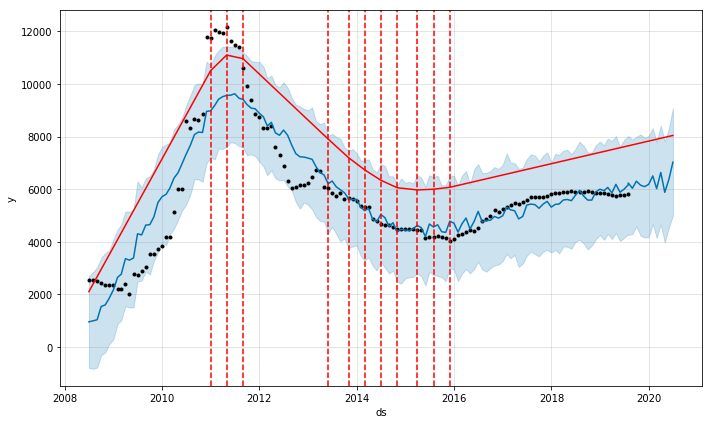

In [44]:
fit_model(prophet_0)

## First Growth vs Second Wines

In [45]:
first_growth = ['Lafite Rothschild','Margaux','Latour','Mouton Rothschild','Haut Brion']
second_wines = ['Carruades Lafite','Pavillon Rouge (Margaux)','Forts Latour','Petit Mouton','Clarence Haut Brion']

In [46]:
first_growth_trend = wine_avg_prices[first_growth].mean(axis=1)
second_wines_trend = wine_avg_prices[second_wines].mean(axis=1)

### Trend of First Growth 

In [58]:
# data formatting 
first_data = first_growth_trend.copy()
first_data = first_data.reset_index()
first_data = first_data.rename(columns={'index':'ds',0:'y'})

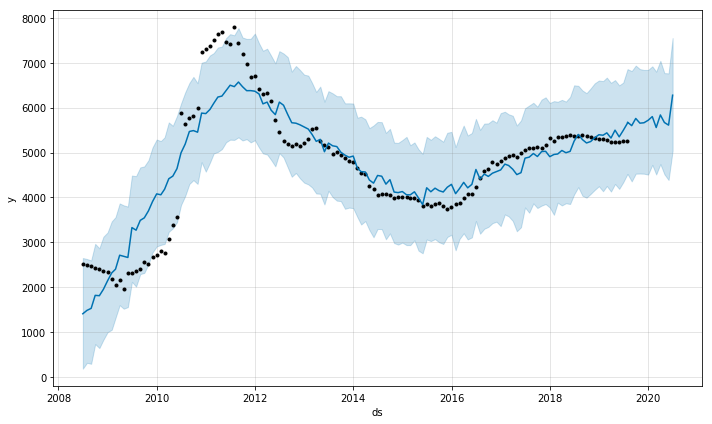

In [60]:
first_m,first_forcast = fit_model(first_data)

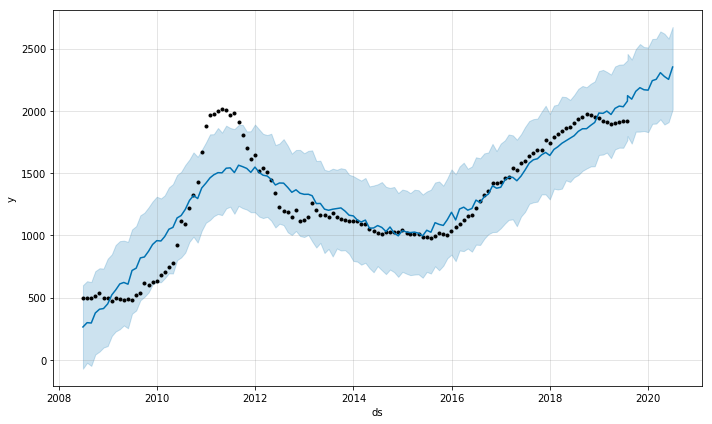

In [61]:
second_data = second_wines_trend.copy()
second_data = second_data.reset_index()
second_data = second_data.rename(columns={'index':'ds',0:'y'})
second_m,second_forcast = fit_model(second_data)

### Monthly Data

In [122]:
def fit_monthly_model(df):
    m = Prophet(seasonality_mode='multiplicative',changepoint_prior_scale=0.1).fit(df)
    future = m.make_future_dataframe(periods=12, freq='M')
    fcst = m.predict(future)
    m.plot(fcst)
    return fcst

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


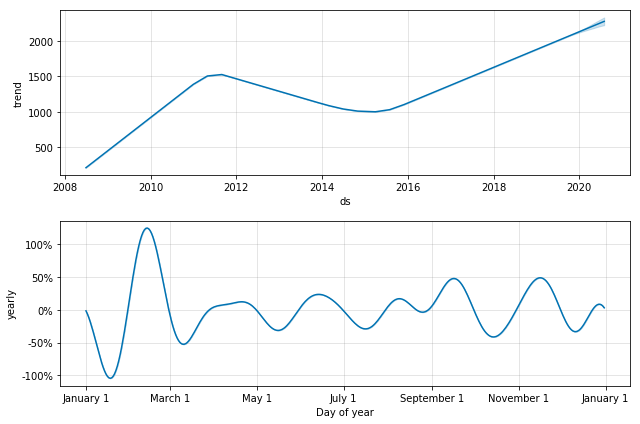

In [114]:
def fit_monthly_decompose(df):
    m = Prophet(seasonality_mode='multiplicative',changepoint_prior_scale=0.1).fit(df)
    future = m.make_future_dataframe(periods=12, freq='M')
    fcst = m.predict(future)
    fig = m.plot_components(fcst)
fit_monthly_decompose(second_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


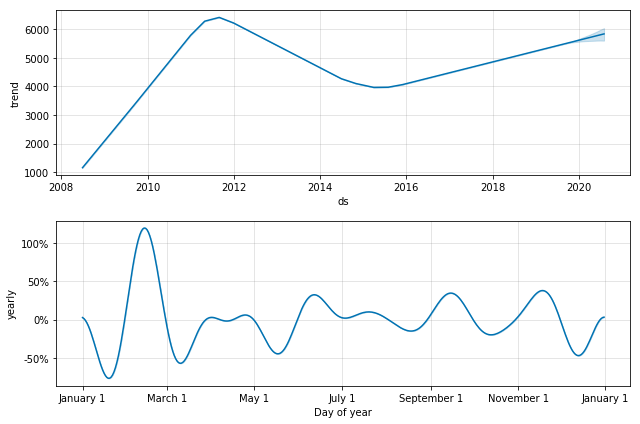

In [115]:
fit_monthly_decompose(first_data)

### Performance 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


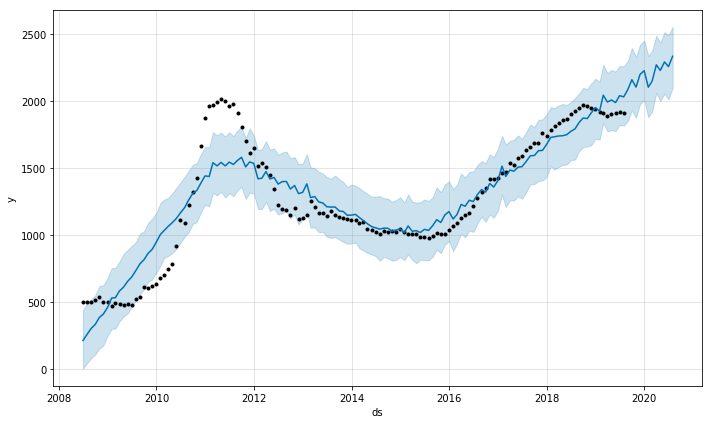

In [124]:
second_result = fit_monthly_model(second_data)

In [125]:
second_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
141,2020-03-31,2272.805636,2063.683615,2491.597670
142,2020-04-30,2230.737693,2001.105345,2436.605470
143,2020-05-31,2294.265726,2056.592843,2517.405458
144,2020-06-30,2259.466479,2016.041235,2492.796416
145,2020-07-31,2336.690802,2099.577952,2555.479749


In [128]:
second_data.tail()

,ds,y
129,2019-03-31,1892.540260
130,2019-04-30,1905.441558
131,2019-05-31,1913.516883
132,2019-06-30,1918.672727
133,2019-07-31,1914.415584


In [139]:
print(2336.690802-1914.415584)
print((2336.690802-1914.415584)/1914.415584)

422.275218
0.22057656734996572


In [149]:
second_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
134,2019-08-31,2088.492518,1852.913213,2302.007399
135,2019-09-30,2161.685274,1932.487293,2398.471101
136,2019-10-31,2106.198413,1878.873702,2331.033656
137,2019-11-30,2200.654423,1979.608924,2423.103503
138,2019-12-31,2229.114674,2008.830110,2454.105779
139,2020-01-31,2105.398668,1881.457582,2338.519539
140,2020-02-29,2151.743655,1924.274843,2377.553246
141,2020-03-31,2272.805636,2063.683615,2491.597670
142,2020-04-30,2230.737693,2001.105345,2436.605470
143,2020-05-31,2294.265726,2056.592843,2517.405458


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


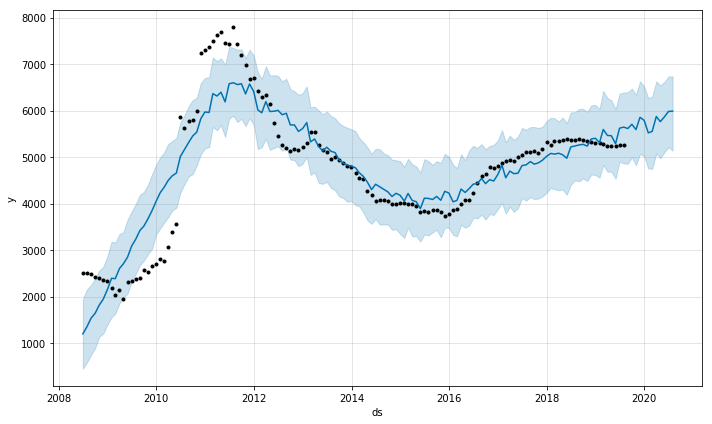

In [130]:
first_result = fit_monthly_model(first_data)

In [148]:
first_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
134,2019-08-31,5613.391042,4856.170845,6393.548230
135,2019-09-30,5703.793220,4997.189274,6471.277554
136,2019-10-31,5590.000281,4822.826649,6338.874911
137,2019-11-30,5854.243534,5069.087116,6627.115402
138,2019-12-31,5788.856397,5018.572052,6518.259033
139,2020-01-31,5520.430438,4752.899575,6265.791699
140,2020-02-29,5550.698913,4747.358556,6296.070109
141,2020-03-31,5872.039527,5077.826076,6627.720477
142,2020-04-30,5761.263592,4972.198498,6540.409189
143,2020-05-31,5864.902048,5105.746711,6614.489482


In [134]:
first_data.tail()

,ds,y
129,2019-03-31,5233.087273
130,2019-04-30,5242.040000
131,2019-05-31,5233.509091
132,2019-06-30,5254.974545
133,2019-07-31,5254.712727


In [138]:
print(6735.504870-5254.712727)
print((6735.504870-5254.712727)/5254.712727)

1480.7921429999997
0.28180268264549024


In [146]:
first_data.describe()

,y
count,134.000000
mean,4714.198465
std,1396.010796
min,1953.400000
25%,3898.232500
50%,4942.121111
75%,5343.590000
max,7796.750000


In [147]:
second_data.describe()

,y
count,134.000000
mean,1274.194881
std,463.268244
min,473.125000
25%,1013.058036
50%,1173.233333
75%,1681.005000
max,2014.200000


### Change Point 

In [140]:
from fbprophet.plot import add_changepoints_to_plot

In [143]:
def check_change_point(df):
    m = Prophet(seasonality_mode='multiplicative',changepoint_prior_scale=0.1).fit(df)
    future = m.make_future_dataframe(periods=12, freq='M')
    fcst = m.predict(future)
    fig = m.plot(fcst)
    a = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


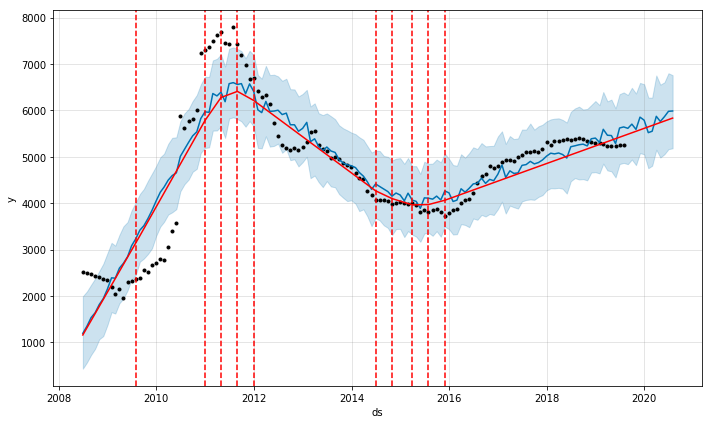

In [144]:
check_change_point(first_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


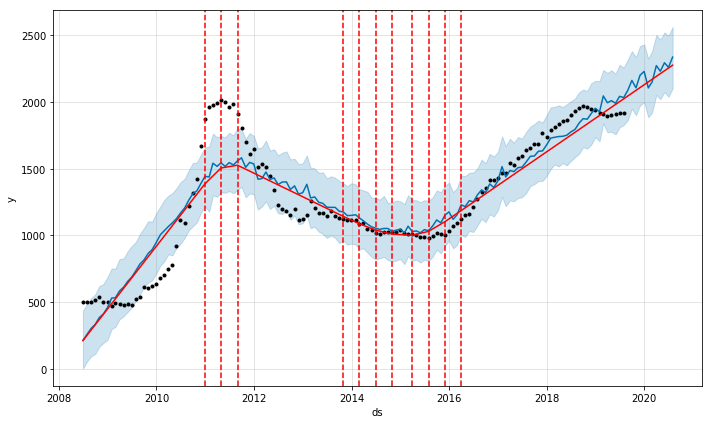

In [145]:
check_change_point(second_data)

### Train Test

In [27]:
my_model = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True) #设置置信空间为95%(如果不设置的话默认80%)
my_model.fit(wine)

In [31]:

future = my_model.make_future_dataframe(periods=365)
print(future.head())

          ds
0 2008-06-30
1 2008-07-31
2 2008-08-31
3 2008-09-30
4 2008-10-31


In [65]:
wine = wine_list[3][2007]
wine = wine.reset_index()

In [66]:
wine = wine.rename(columns={'index':'ds',2007:'y'})

In [97]:
def train_test_split(data):
    train = data[:122]
    test = data[122:]
    return train, test
train, test = train_test_split(wine)

In [98]:
m = Prophet(changepoint_prior_scale=0.1,daily_seasonality=True,weekly_seasonality=True)
m.fit(train)

In [108]:
future = m.make_future_dataframe(periods=12,freq='MS')
future.tail()

,ds
129,2019-03-01
130,2019-04-01
131,2019-05-01
132,2019-06-01
133,2019-07-01


In [109]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
129,2019-03-01,2859.273430,2681.478182,3032.707630
130,2019-04-01,2881.207680,2707.270889,3060.957199
131,2019-05-01,2823.625153,2645.937856,2992.207588
132,2019-06-01,2775.146458,2613.031381,2960.192751
133,2019-07-01,2985.351167,2802.719354,3160.272001


In [110]:
temp = np.asarray(forecast[[ 'yhat']]).flatten()

In [120]:
ans = []
for i in np.asarray(test):
    ans.append(i[1])

In [121]:
ans

[2714.0,
 2690.0,
 2690.0,
 2286.0,
 2300.0,
 2662.0,
 2700.0,
 2700.0,
 2700.0,
 2540.0,
 2400.0,
 2400.0]

In [122]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(ans,temp[122:] ))
print(rms)

264.7351142509767


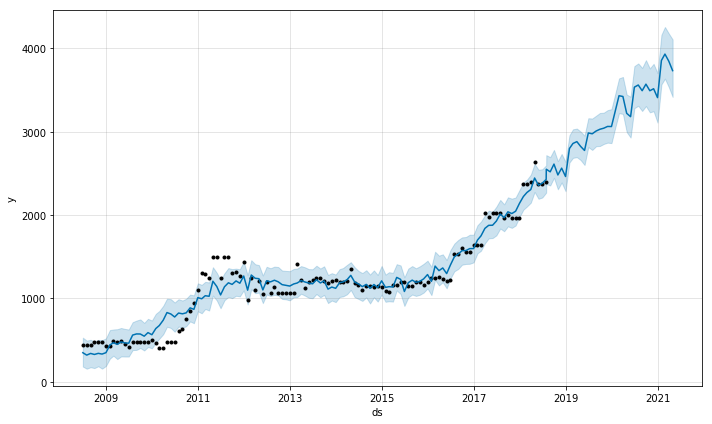

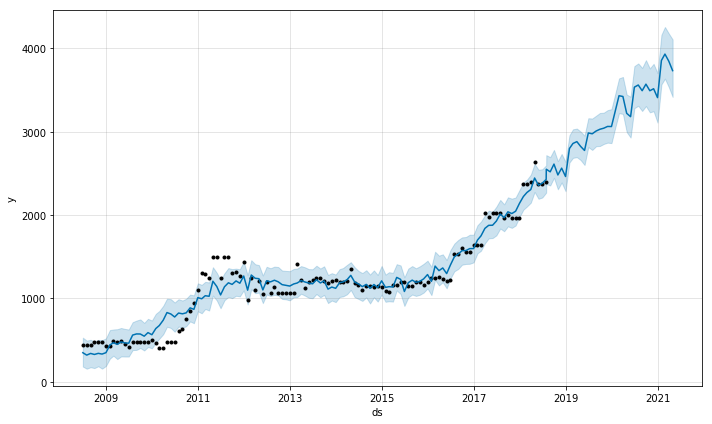

In [104]:
m.plot(forecast)

In [94]:
df.set_index(wine_list[3][2007].index)

,yhat
0,285.498799
1,333.047527
2,361.923142
3,374.918263
4,335.387516
5,358.126777
6,375.512868
7,395.487419
8,493.376861
9,446.707380


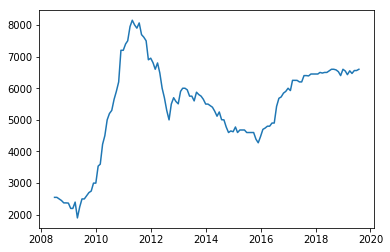

In [40]:
plt.plot(wine_list[0][2007])

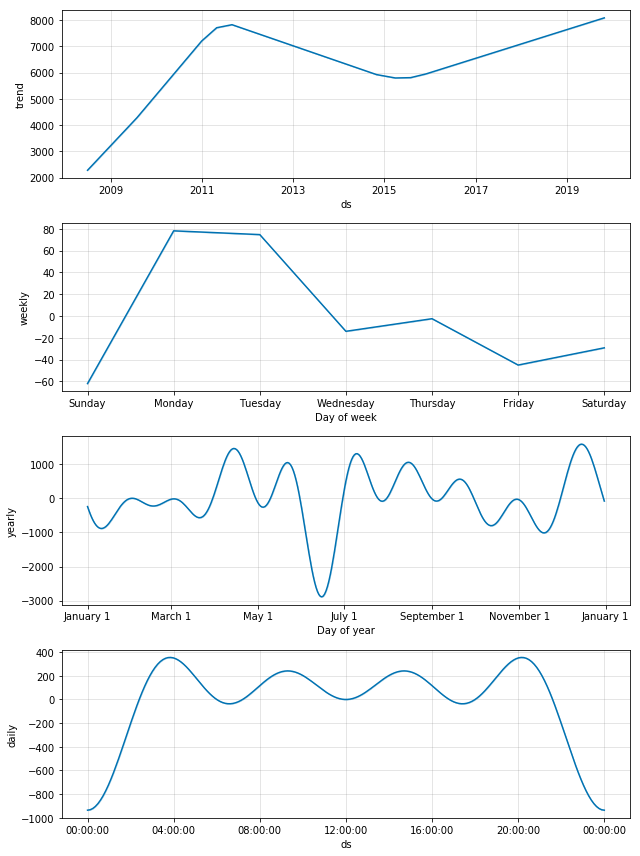

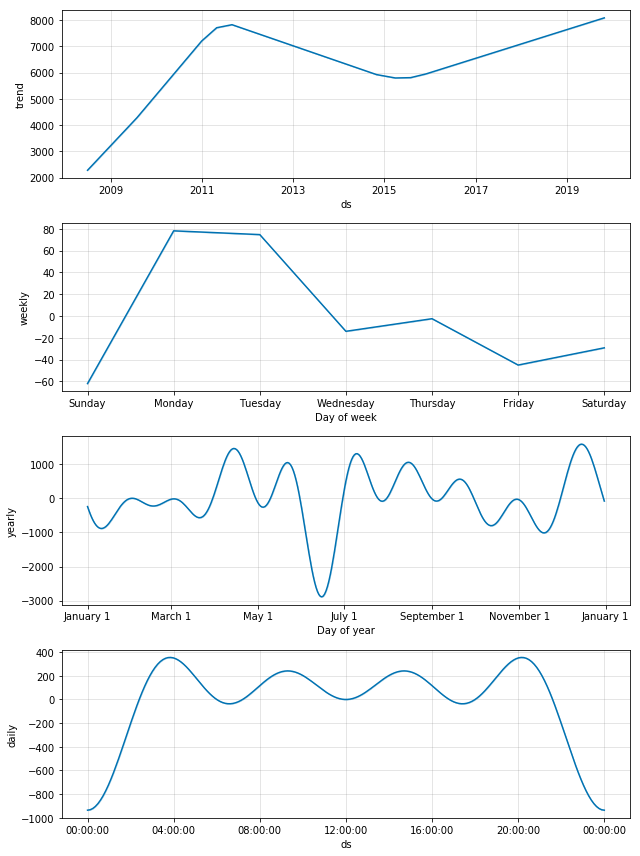

In [57]:
m.plot_components(forecast)

In [78]:
pd.plotting.register_matplotlib_converters()